In [4]:
#Load libraries

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


from skimage.util import montage 
from skimage.transform import rotate

from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

import random
import cv2


import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import img_to_array

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchvision import models
# from torchvision import transforms

# from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC,SVR

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize


import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import sklearn.metrics as metrics

from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,auc

import seaborn as sns
from tqdm import tqdm

#VGG
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import montage
from skimage.transform import rotate

from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

import random
import cv2

from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model
from keras import Input
from pickle import dump

import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Flatten

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC, SVR

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  ConfusionMatrixDisplay,classification_report
from scikitplot.metrics import confusion_matrix

import matplotlib as mpl

import torch
import numpy as np
from tqdm import tqdm


In [5]:
df_ids = pd.read_csv("D:/GBMFeatures/train/MGMT_OS.csv")

In [6]:
df_ids.head()

,ID,MGMT,Survival_binary
0,UPENN-GBM-00091_11,0,0
1,UPENN-GBM-00093_11,0,1
2,UPENN-GBM-00094_11,0,1
3,UPENN-GBM-00095_11,1,0
4,UPENN-GBM-00098_11,1,1


In [7]:
# Define the modalities you want to use
modalities = ["FLAIR", "T1GD", "T1", "T2"]

class ModelFeatureExtractor:
    def __init__(self, model, modalities):
        self.model_name = model
        self.modalities = modalities
        self.features_avg_res = []  # Empty list to store average features extracted by VGG
        self.features_std_res = []  # Empty list to store standard deviation of features extracted by VGG

        
        if model=="ResNet-50":
           
            # Load ResNet-50 model with pre-trained weights
            resnet_model = models.resnet50(pretrained=True)
            
            # Feature extraction layers of ResNet
            features_layer = nn.Sequential(*list(resnet_model.children())[:-1])
            
            # Apply global average pooling to reduce spatial dimensions to 1x1
            global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

            # Flatten the output feature maps
            resnet = nn.Sequential(features_layer, global_avg_pool, nn.Flatten())

            self.model = resnet



            
    def interpolate(self, new_image_data):
        h, w = 224, 224  # Target height and width for interpolation
        dim = (w, h)  # Tuple representing the target dimensions
        final_image = cv2.resize(new_image_data, dim, interpolation=cv2.INTER_CUBIC)
        # Resize the new image data to the target dimensions using bicubic interpolation

        return final_image

    
    def convert(self,image,model):
        if model == "ResNet-50":
            
              # Resize the image to 224x224
            image_new = cv2.resize(image, (224, 224))

            # Normalize the image to values between 0 and 1
            image_new = (image_new - np.min(image_new)) / (np.max(image_new) - np.min(image_new))

            # Convert the image to RGB by stacking the grayscale image 3 times
            image_new = np.stack((image_new,)*3, axis=-1)

            # Reshape the image to (1, 224, 224, 3) so that it suits resnet-50
            image_new = np.expand_dims(image_new, axis=0)

            return image_new



    def slice_range(self, image_data_seg):
        slices = 155  # Total number of slices
        start = 0  # Initial value for the start slice
        end = 154  # Initial value for the end slice

        # Find the start slice
        for n_slice in range(slices):
            image = image_data_seg[:, :, n_slice]

            # Check if the image contains specific values (1, 2, or 4) and has more than 300 nonzero elements
            if (1 in image or 2 in image or 4 in image) and np.count_nonzero(image) > 300:
                start = n_slice
                break

        # Find the end slice
        for n_slice in range(slices-1, -1, -1):
            image = image_data_seg[:, :, n_slice]

            # Check if the image contains specific values (1, 2, or 4) and has more than 300 nonzero elements
            if (1 in image or 2 in image or 4 in image) and np.count_nonzero(image) > 300:
                end = n_slice
                break

        return start, end

    def bbox(self, img):
        # Find the rows and columns that contain nonzero elements
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)

        # Find the minimum and maximum row indices that contain nonzero elements
        rmin, rmax = np.where(rows)[0][[0, -1]]

        # Find the minimum and maximum column indices that contain nonzero elements
        cmin, cmax = np.where(cols)[0][[0, -1]]

        return rmin, rmax, cmin, cmax


    def preprocess_image_slices(self, patient_id, modality, model):
        # Add your preprocess_image_slices logic here
        
        # Load image data
        image_path = f'D:/GBMFeatures/train/images_structural/{patient_id}/{patient_id}_{modality}.nii.gz'
        image_data = nib.load(image_path).get_fdata()

        # Load segmentation data
        seg_path = f'D:/GBMFeatures/train/automated_segm/{patient_id}_automated_approx_segm.nii.gz'
        image_data_seg = nib.load(seg_path).get_fdata()

        # Compute bounding box and slice range
        rmin, rmax, cmin, cmax = self.bbox(image_data_seg)
        start, end = self.slice_range(image_data_seg)
        size = end - start + 1

        # Preprocess image slices
        if model == "ResNet-50":
            x = np.zeros((size,224,224,3),dtype=np.float32)

        for i in range(start, end+1):
            # Extract a 2D slice from the 3D image volume
            new_image_data = image_data[rmin:rmax+1, cmin:cmax+1, i]

            # Resize the image to 224x224 and convert to RGB format
            final_image = self.interpolate(new_image_data)
            final_image = self.convert(final_image,model)

            # Add the processed image slice to the input tensor
            x[i-start] = final_image

        return x


    


    def extract_features_res(self, df_ids):
        for ind, patient_id in tqdm(enumerate(df_ids['ID']), total=len(df_ids['ID'])):
            features_row_avg_res = np.array([])  # Initialize as an empty array
            features_row_std_res = np.array([])  # Initialize as an empty array

            for modality in modalities:
        # Preprocess image slices
                x = self.preprocess_image_slices(patient_id, modality, self.model_name)

        # Ensure that x is a NumPy array with shape (224, 224, 3)
        # Resize, normalize, and convert to RGB as needed
                x_torch = torch.from_numpy(x).permute(0, 3, 1, 2).float()
        #Converts the processed images to PyTorch tensors (x_torch) and performs a forward pass 
        # Extract features using pre-trained ResNet-50
                with torch.no_grad():
                    features_tensor = self.model(x_torch)
                features_numpy = features_tensor.squeeze().numpy()  # Remove the batch dimension

        # Calculate average and standard deviation along axis 1 (features dimension)
                avg_features = np.average(features_numpy, axis=0)  # Calculate average across all spatial dimensions
                std_features = np.std(features_numpy, axis=0)  # Calculate std dev across all spatial dimensions

                # Append calculated features to the patient's feature lists
                if len(features_row_avg_res) == 0:
                    features_row_avg_res = avg_features
                    features_row_std_res = std_features
                else:
                    features_row_avg_res = np.concatenate([features_row_avg_res, avg_features],axis=0)
                    features_row_std_res = np.concatenate([features_row_std_res, std_features],axis=0)

    # Append the current patient's feature lists to the overall feature lists
            self.features_avg_res.append(features_row_avg_res)
            self.features_std_res.append(features_row_std_res)


In [9]:
# Create an instance of ModelFeatureExtractor with "ResNet-50" model and specified modalities
resnet_extractor = ModelFeatureExtractor("ResNet-50", modalities)

# Extract features using the ResNet-50 model for the given DataFrame of IDs (df_ids)
resnet_extractor.extract_features_res(df_ids)


100%|██████████| 50/50 [36:42<00:00, 44.06s/it]


In [10]:
#Convert to dataframe
panda_features_avg_res = pd.DataFrame(data = resnet_extractor.features_avg_res)
panda_features_std_res = pd.DataFrame(data = resnet_extractor.features_std_res)


In [11]:
panda_features_avg_res.shape, panda_features_std_res.shape

((50, 8192), (50, 8192))

In [13]:
# Rename columns properly

# Define the modalities and features
modalities = ["FLAIR", "T1GD", "T1", "T2"]
# n_features_alex = 256
n_features_res = 2048

# Create a list of new column names


columns_avg_res = [f"{modality}_ResNet-50_Avg_F{i}" for modality in modalities for i in range(n_features_res)]
columns_std_res  = [f"{modality}_ResNet-50_Std_F{i}" for modality in modalities for i in range(n_features_res)]



panda_features_avg_res.columns = columns_avg_res
panda_features_std_res.columns = columns_std_res


In [14]:


# Concatenate the average and standard deviation dataframes column-wise for ResNet
final_res_features = pd.concat([panda_features_avg_res, panda_features_std_res], axis=1)


In [15]:

final_res_features.to_csv(f"D:/GBMFeatures/train/FEATURES_FINAL/final_res_features.csv",index=False,header = final_res_features.columns)

In [16]:

from sklearn.feature_selection import RFE
from sklearn.svm import SVC

# Create an SVM estimator
svm_estimator = SVC(kernel='linear')

# Set the number of features to keep
n_features = 60

features = ["res"]
targets = ["MGMT","Survival_binary"]

df_ids = pd.read_csv("D:/GBMFeatures/train/MGMT_OS.csv")

for target in targets:
    for feature_type in features:
        
        feature_set = pd.read_csv(f"D:/GBMFeatures/train/FEATURES_FINAL/final_{feature_type}_features.csv")

        # Create an RFE object
        rfe = RFE(estimator=svm_estimator, n_features_to_select=n_features, step=1, verbose=0)

        # Fit the RFE object on the concatenated features
        rfe.fit(feature_set, df_ids[target].values.ravel())

        # Get the selected features
        selected_features = feature_set.iloc[:, rfe.support_]
        
        selected_features_df = pd.DataFrame(data = selected_features)
        selected_features.to_csv(f"D:/GBMFeatures/train/FEATURES_FINAL/{target}/final_{feature_type}_features_{n_features}.csv",index=False,header=selected_features_df.columns)

In [17]:
# MGMT Prediction
import pickle


class_weights = {0: 1, 1: 1.4}

target = 'MGMT'
n_features = 60

concatenated_features = pd.read_csv(f"D:/GBMFeatures/train/FEATURES_FINAL/{target}/final_res_features_{n_features}.csv")
concatenated_features_mgmt = concatenated_features
target_df = pd.read_csv("D:/GBMFeatures/train/MGMT_OS.csv")[target]

# Step 6: Train an SVM model using Stratified Kfold cross validation and grid search cv
scaler = StandardScaler()
svc = SVC(probability=True, class_weight=class_weights)

param_grid = {
    'C': [0.1, 1, 10,100],
    'kernel': ['linear','poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
best_svc = None
best_score = 0
best_scaler = None

# Initialize empty arrays to store the true and predicted labels
all_y_test = np.array([])
all_y_pred = np.array([])

for i, (train, test) in enumerate(cv.split(concatenated_features, target_df)):
    X_train = concatenated_features.iloc[train,:]
    y_train = target_df.iloc[train].values.ravel()
    X_test = concatenated_features.iloc[test,:]
    y_test = target_df.iloc[test].values.ravel()

    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='roc_auc',verbose=0)
    
    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Transform the training and testing data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    grid_search.fit(X_train_scaled, y_train)
    best_svc_fold = grid_search.best_estimator_
    
    score = grid_search.best_score_
    if score > best_score:
        
        best_score = score
        best_svc = best_svc_fold
        best_scaler = scaler
    
    y_score = best_svc_fold.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    print('Fold %d ROC AUC: %.4f' % (i+1, roc_auc))
    pickle.dump(best_svc_fold, open('model.pkl', 'wb'))
    



Fold 1 ROC AUC: 1.0000
Fold 2 ROC AUC: 1.0000
Fold 3 ROC AUC: 1.0000
Fold 4 ROC AUC: 1.0000
Fold 5 ROC AUC: 1.0000


## OS

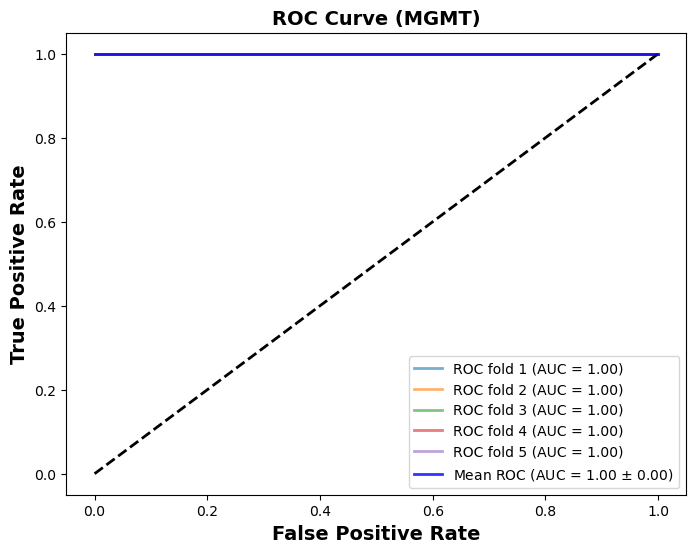

Accuracy: 0.9000
Precision: 1.0000
Recall: 0.8000
Specificity: 1.0000
F1-Score: 0.8889


In [18]:
# create confusion matrix display

y_pred = best_svc_fold.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
    
     # Store the true and predicted labels for this fold
all_y_test = np.concatenate([all_y_test, y_test])
all_y_pred = np.concatenate([all_y_pred, y_pred])
    

plt.figure(figsize=(8,6))
for i in range(len(tprs)):
    plt.plot(mean_fpr, tprs[i], lw=2, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

plt.plot([0,1],[0,1],'--',lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

# plt.fill_between(mean_fpr, mean_tpr - std_auc, mean_tpr + std_auc, alpha=.2, color='b')
plt.xlabel('False Positive Rate',fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=14, fontweight='bold')
plt.title('ROC Curve (MGMT)',fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('auc_roc_MGMT.png',dpi=1000)
plt.show()

# Calculate the mean confusion matrix
mean_cm = confusion_matrix(all_y_test, all_y_pred) / cv.get_n_splits()

# calculate the confusion matrix for all folds
cm = confusion_matrix(all_y_test, all_y_pred)

# calculate the evaluation metrics for all folds
tn, fp, fn, tp = cm.ravel()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)
f1_score = 2*((precision*recall)/(precision+recall))

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Specificity: {:.4f}".format(specificity))
print("F1-Score: {:.4f}".format(f1_score))


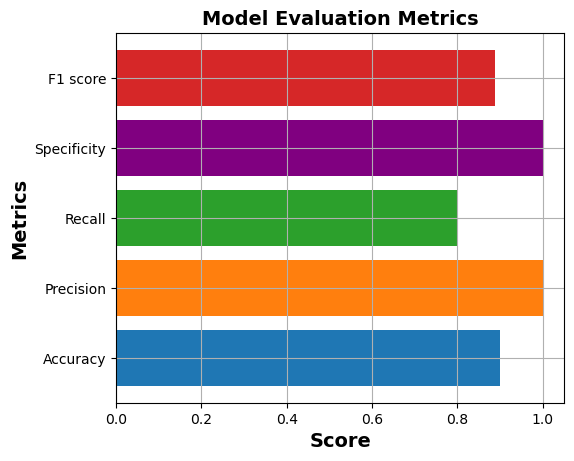

In [2]:
import matplotlib.pyplot as plt
 
# Data
labels = ['Accuracy',  'Precision', 'Recall','Specificity','F1 score',]
values = [0.9000, 1.000, 0.8000, 1.000,0.8889]

# Accuracy: 0.7689
# Precision: 0.6506
# Recall: 0.7297
# Specificity: 0.7899
# F1-Score: 0.6879
    
# Creating axes object
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.2)

# Creating a horizontal bar graph
ax.barh(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c','#800080', '#d62728'])
 
# Setting grid lines
ax.grid(True)
 
# Setting X-axis label
ax.set_xlabel('Score',fontsize=14, fontweight='bold')
 
# Setting Y-axis label
ax.set_ylabel('Metrics',fontsize=14, fontweight='bold')
 
# Title of the plot
ax.set_title('Model Evaluation Metrics',fontsize=14, fontweight='bold')
 
plt.savefig('performance_metrics_mgmt.png')

# Displaying the plot
plt.show()
